In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from tqdm import tqdm
from functools import partialmethod

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# dark_palette = ['#3E4095','#9F3E4B','#4D9458','#5D4774','#ADAA27']
# light_palette = ['#A6ABE4','#E3A3A7','#B2D9B8','#C6B9CF','#D9D89F']

In [26]:
df = pd.read_excel('datos.xlsx')

In [27]:
pipeline_categorical = make_pipeline(
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            FunctionTransformer(
                                func=lambda x: x.astype('category'),
                                feature_names_out= 'one-to-one'
                            )
                        )

transformer_exog = make_column_transformer(
                        (
                            pipeline_categorical,
                            make_column_selector(dtype_exclude=np.number)
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                    ).set_output(transform="pandas")

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1]
}

lags_grid = [1,2]

In [28]:
# Create forecaster
forecaster = ForecasterAutoreg(
               regressor = LGBMRegressor(random_state=42
                                         ,min_data_in_bin = 2
                                         ,min_data_in_leaf = 2),
               lags = 2,
               transformer_exog = transformer_exog
            )

In [29]:
# data = df
# serie = 'v_total'
# temp = data[serie]
# data = data.loc[:, ~data.columns.str.startswith('ru_')]
# data = data.drop(columns=['v_total', 'v_super', 'v_retail', 'v_cowork'])
# data = data.drop(columns=['int_ret_sup','int_ret_cow','int_sup_cow','porc_retail','porc_super','porc_cowork'])
# data[serie] = temp
# data.set_index('mes', inplace=True)

In [30]:
def predecir_LightGBM(data, serie, param_grid, lags_grid):

    temp = data[serie]
    data = data.loc[:, ~data.columns.str.startswith('ru_')]
    data = data.drop(columns=['v_total', 'v_super', 'v_retail', 'v_cowork'])
    data = data.drop(columns=['int_ret_sup','int_ret_cow','int_sup_cow','porc_retail','porc_super','porc_cowork'])
    data[serie] = temp
    data.set_index('mes', inplace=True)

    exog_features = [x for x in data.columns if x != serie]

    end_train = '2021-08-01'
    end_validation = '2022-08-01'
    data_train = data.loc[: end_train, :]
    data_val   = data.loc[end_train:end_validation, :]
    data_test  = data.loc[end_validation:, :]

    data.reset_index(inplace=True)

    results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data.loc[:end_validation, serie],
                    exog               = data.loc[:end_validation, exog_features],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = 12, #len(data.loc[:end_train]),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False,
                    show_progress      = False
                )

    metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[serie],
                        exog               = data[exog_features],
                        initial_train_size = len(df.loc[:end_validation]),
                        fixed_train_size   = False,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        verbose            = False
                    )
    print(f"Backtest error: {metric:.2f}")

    data['pred'] = predictions

    info = (f"MSE: {mean_squared_error(data_test[serie], predictions['pred'][-13:]):.2e}\nMAE:{mean_absolute_error(data_test[serie][-13:], predictions['pred'][-13:]):.2e} \nRMSE: {np.sqrt(mean_squared_error(data_test[serie][-13:], predictions['pred'][-13:])):.2e}")
    print(info)

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    plt.plot(data['pred'][-13:], color='green',label='Predicciones', alpha=0.5)
    plt.plot(data[serie][1:], color='orange', markersize=6, label='Originales')
    plt.title(f'Prediccion LightGBM Serie: {serie}')
    plt.text(5.5,5.5,info)

    return fig

Number of models compared: 24.
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 11, number of used features: 28
[LightGBM] [Info] Start training from score 8228315.454545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

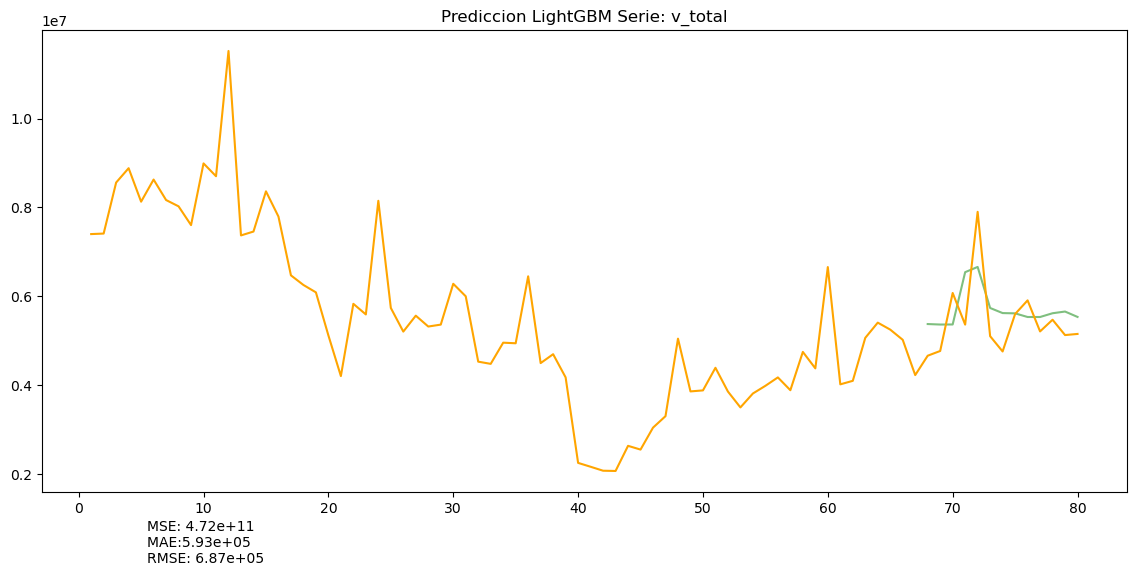

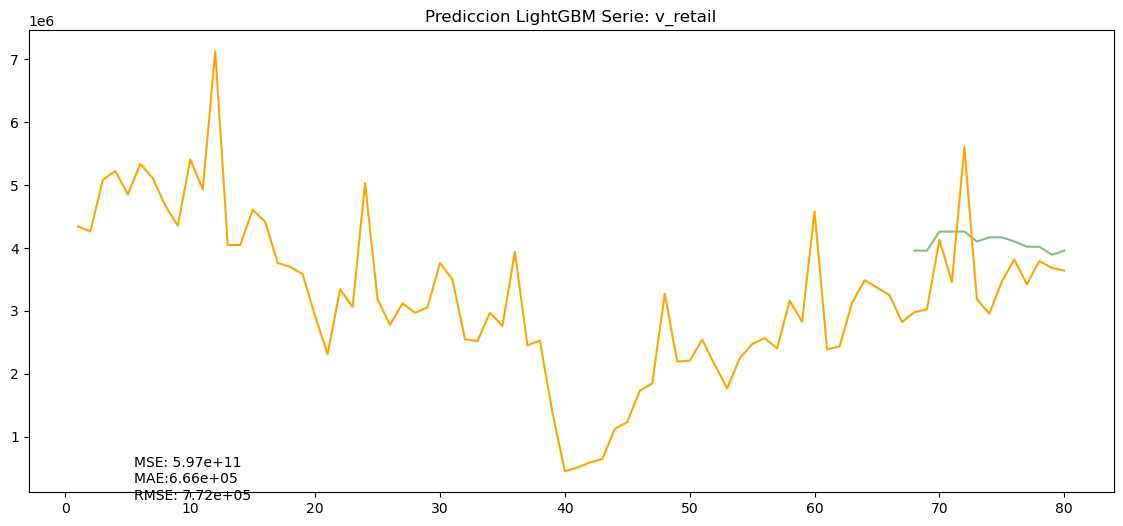

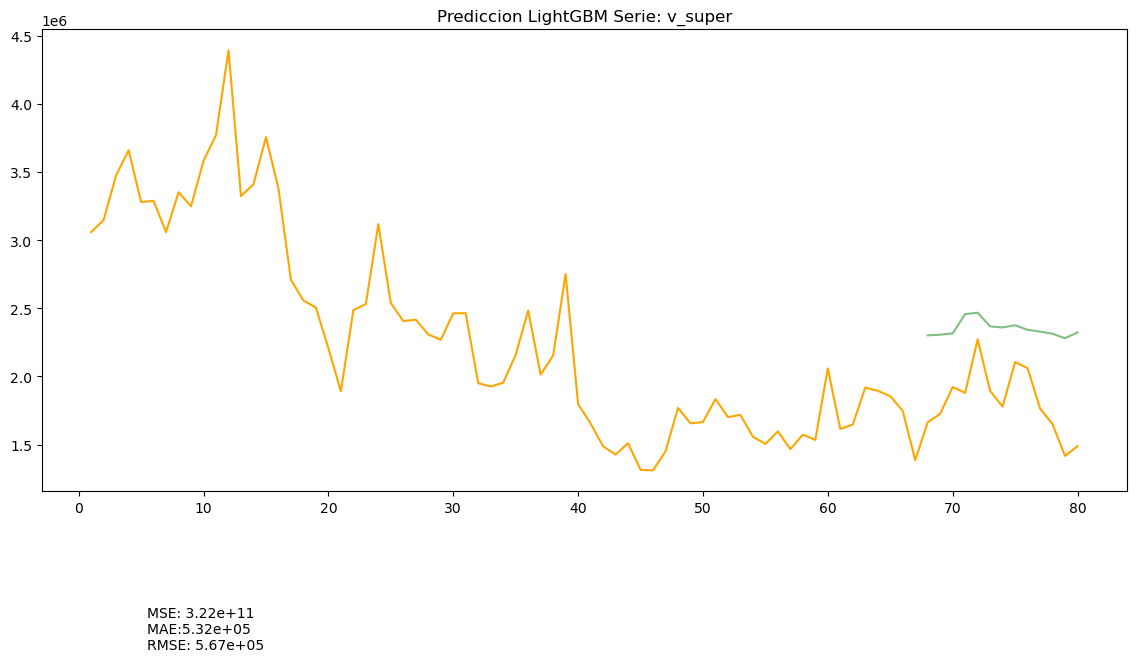

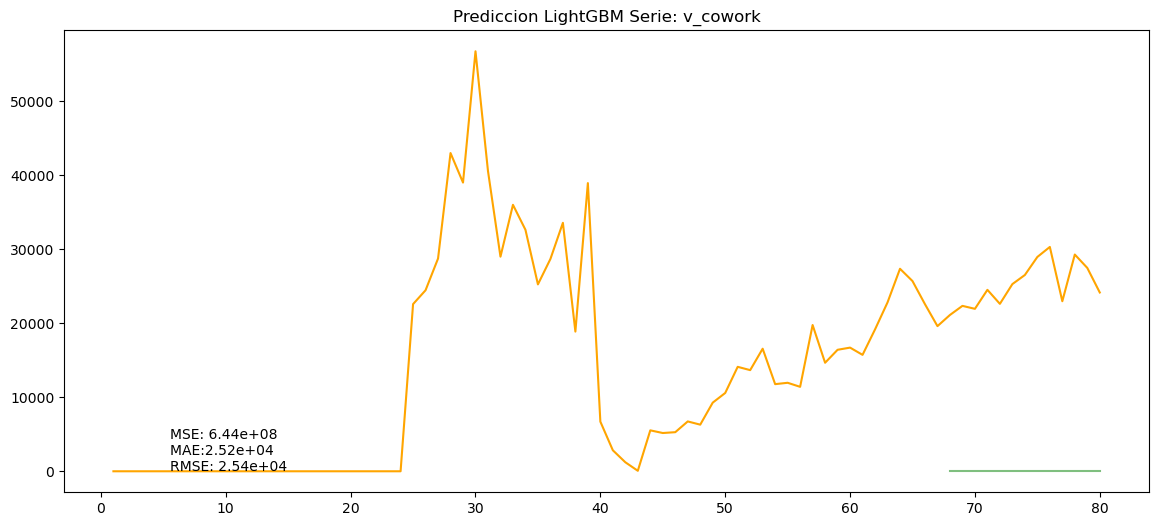

In [31]:
fig_total = predecir_LightGBM(df, 'v_total', param_grid, lags_grid)
fig_retail = predecir_LightGBM(df, 'v_retail', param_grid, lags_grid)
fig_super = predecir_LightGBM(df, 'v_super', param_grid, lags_grid)
fig_cowork = predecir_LightGBM(df, 'v_cowork', param_grid, lags_grid)

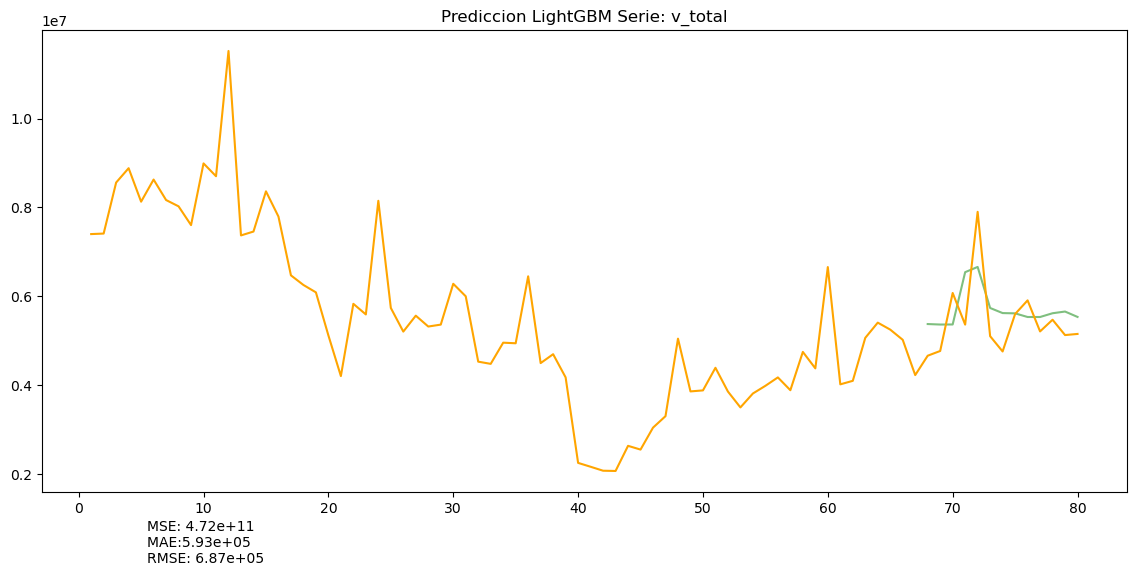

In [32]:
fig_total

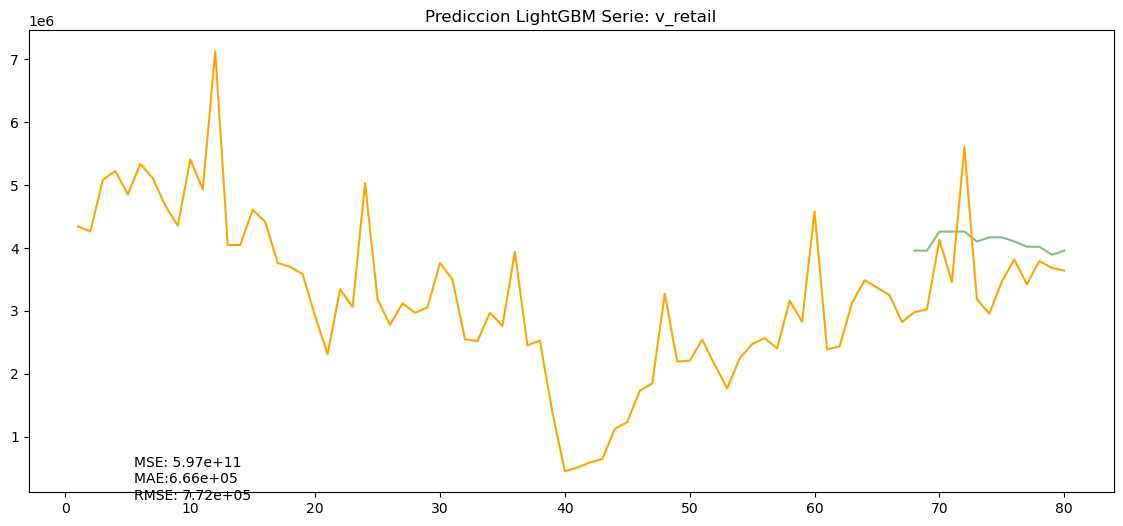

In [33]:
fig_retail

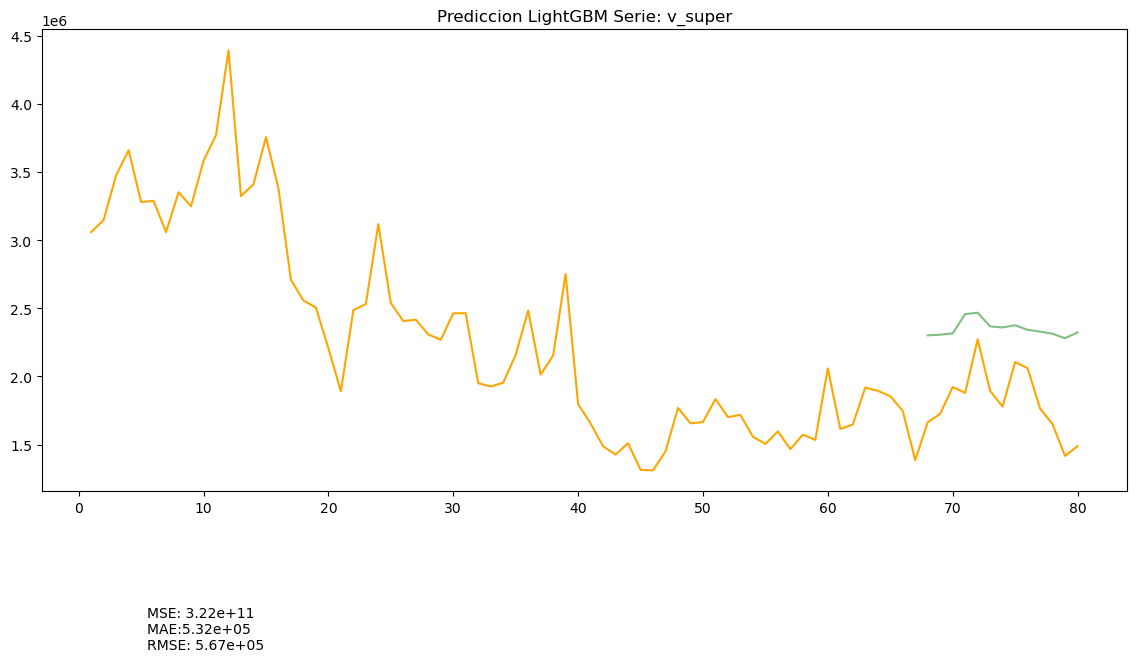

In [34]:
fig_super

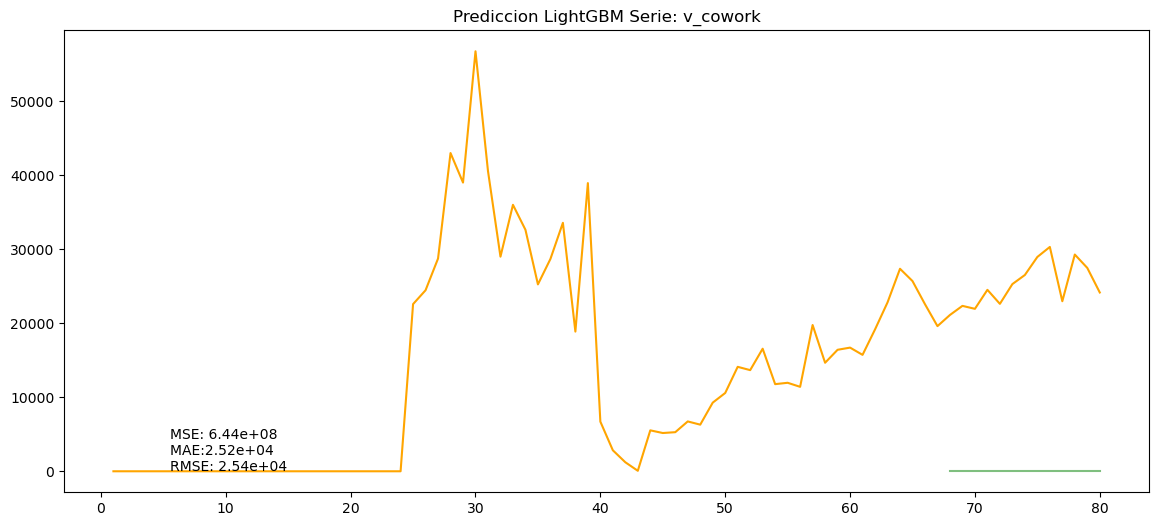

In [35]:
fig_cowork

In [36]:
# exog_features = [x for x in df.columns if x != serie]

# end_train = '2021-08-01'
# end_validation = '2022-08-01'
# data_train = df.loc[: end_train, :]
# data_val   = df.loc[end_train:end_validation, :]
# data_test  = df.loc[end_validation:, :]

# X_train, y_train = forecaster.create_train_X_y(
#                     y = df.loc[:end_validation, serie],
#                     exog = df.loc[:end_validation, exog_features]
#                )

In [37]:
# df.loc[:end_train, 'partition'] = 'train'
# df.loc[end_train:end_validation, 'partition'] = 'validation'
# df.loc[end_validation:, 'partition'] = 'test'

# fig = px.line(
#     data_frame = df.reset_index(),
#     #x      = 'mes',
#     y      = serie,
#     color  = 'partition',
#     title  = serie,
#     width  = 800,
#     height = 450
# )
# fig.update_layout(
#     width  = 800,
#     height = 400,
#     margin=dict(l=20, r=20, t=35, b=20),
#     legend=dict(
#         orientation="h",
#         yanchor="top",
#         y=1,
#         xanchor="left",
#         x=0.001
#     )
# )
# fig.update_xaxes(rangeslider_visible=True)
# fig.show()
# data=df.drop(columns='partition')
# data.reset_index(drop=False, inplace=True)

In [38]:
#df.loc[:end_validation, serie]

In [39]:
# # Regressor hyperparameters
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [2, 3, 4],
#     'learning_rate': [0.01, 0.1]
# }

# Lags used as predictors
# lags_grid = [1,2]

# results_grid = grid_search_forecaster(
#                     forecaster         = forecaster,
#                     y                  = data.loc[:end_validation, serie],
#                     exog               = data.loc[:end_validation, exog_features],
#                     param_grid         = param_grid,
#                     lags_grid          = lags_grid,
#                     steps              = 36,
#                     refit              = False,
#                     metric             = 'mean_squared_error',
#                     initial_train_size = 12, #len(data.loc[:end_train]),
#                     fixed_train_size   = False,
#                     return_best        = True,
#                     verbose            = False
#                 )

In [40]:
# # Backtesting test data
# # ==============================================================================
# metric, predictions = backtesting_forecaster(
#                         forecaster         = forecaster,
#                         y                  = data[serie],
#                         exog               = data[exog_features],
#                         initial_train_size = len(data.loc[:end_validation]),
#                         fixed_train_size   = False,
#                         steps              = 36,
#                         refit              = False,
#                         metric             = 'mean_squared_error',
#                         verbose            = False
#                     )
# print(f"Backtest error: {metric:.2f}")

In [41]:
#data_test.index[-13:]
# data['pred'] = predictions


In [42]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# plt.plot(data['pred'], color='green',label='Predicciones', alpha=0.5)
# plt.plot(data[serie], color='orange', markersize=6, label='Originales')
# plt.show()

In [43]:
# predictions['pred'][-13:]